In [2]:
#Importing the necessary libraries
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
#from torchsummary import summary
import matplotlib.pyplot as plt
import torch_directml
import os
import argparse
import sys

In [3]:
# Loading the data
train_dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

* A particular kind of neural network called an **overcomplete autoencoder** is made to learn a **compressed version of the input data**. With an overcomplete autoencoder, there are more hidden units in the encoder than there are input layer units. Due to the network bottleneck caused by this, the encoder is compelled to learn a compressed version of the input data.

In [4]:
class OvercompleteAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(OvercompleteAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# Defining the loss functtion and the optimizers
model = OvercompleteAutoEncoder(input_dim=784, hidden_dim=1000)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
device = torch_directml.device()
device

device(type='privateuseone', index=0)

In [7]:
#model.load_state_dict(torch.load(PATH)) 
model.to(device) 

#model.load_state_dict(torch.load(PATH)) 
  
# Move the model to the GPU if available 
#model.to(device) 
#summary(model, (1,784))

OvercompleteAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1000, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

**summary(model, (1, 784))** : 
* **(1, 784):** This tuple represents the shape of the input tensor expected by the model.
  
* **1** is the number of channels (since it's a single-channel input, often used for grayscale images or flattened inputs).
  
* **784** is the feature dimension, which is typical for a flattened 28x28 image (e.g., from the MNIST dataset).

In [9]:
# Training the model
num_epochs = 3
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data=data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        recon_data= model(data)
        loss = criterion(recon_data, data)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Epoch : {} [{} / {} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100.*batch_idx / len(train_loader),
                                                                       loss.item()))

C:\Users\User\anaconda3\envs\ML\lib\site-packages\torch\nn\functional.py:3127: UserWarning: The operator 'aten::binary_cross_entropy' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch._C._nn.binary_cross_entropy(input, target, weight, reduction_enum)


Epoch : 0 [0 / 60000 (0%)]	Loss: 0.692946
Epoch : 0 [12800 / 60000 (21%)]	Loss: 0.692927
Epoch : 0 [25600 / 60000 (43%)]	Loss: 0.692936
Epoch : 0 [38400 / 60000 (64%)]	Loss: 0.692945
Epoch : 0 [51200 / 60000 (85%)]	Loss: 0.692917
Epoch : 1 [0 / 60000 (0%)]	Loss: 0.692928
Epoch : 1 [12800 / 60000 (21%)]	Loss: 0.692944
Epoch : 1 [25600 / 60000 (43%)]	Loss: 0.692937
Epoch : 1 [38400 / 60000 (64%)]	Loss: 0.692928
Epoch : 1 [51200 / 60000 (85%)]	Loss: 0.692906
Epoch : 2 [0 / 60000 (0%)]	Loss: 0.692923
Epoch : 2 [12800 / 60000 (21%)]	Loss: 0.692925
Epoch : 2 [25600 / 60000 (43%)]	Loss: 0.692917
Epoch : 2 [38400 / 60000 (64%)]	Loss: 0.692943
Epoch : 2 [51200 / 60000 (85%)]	Loss: 0.692932


Test Loss: 0.006086


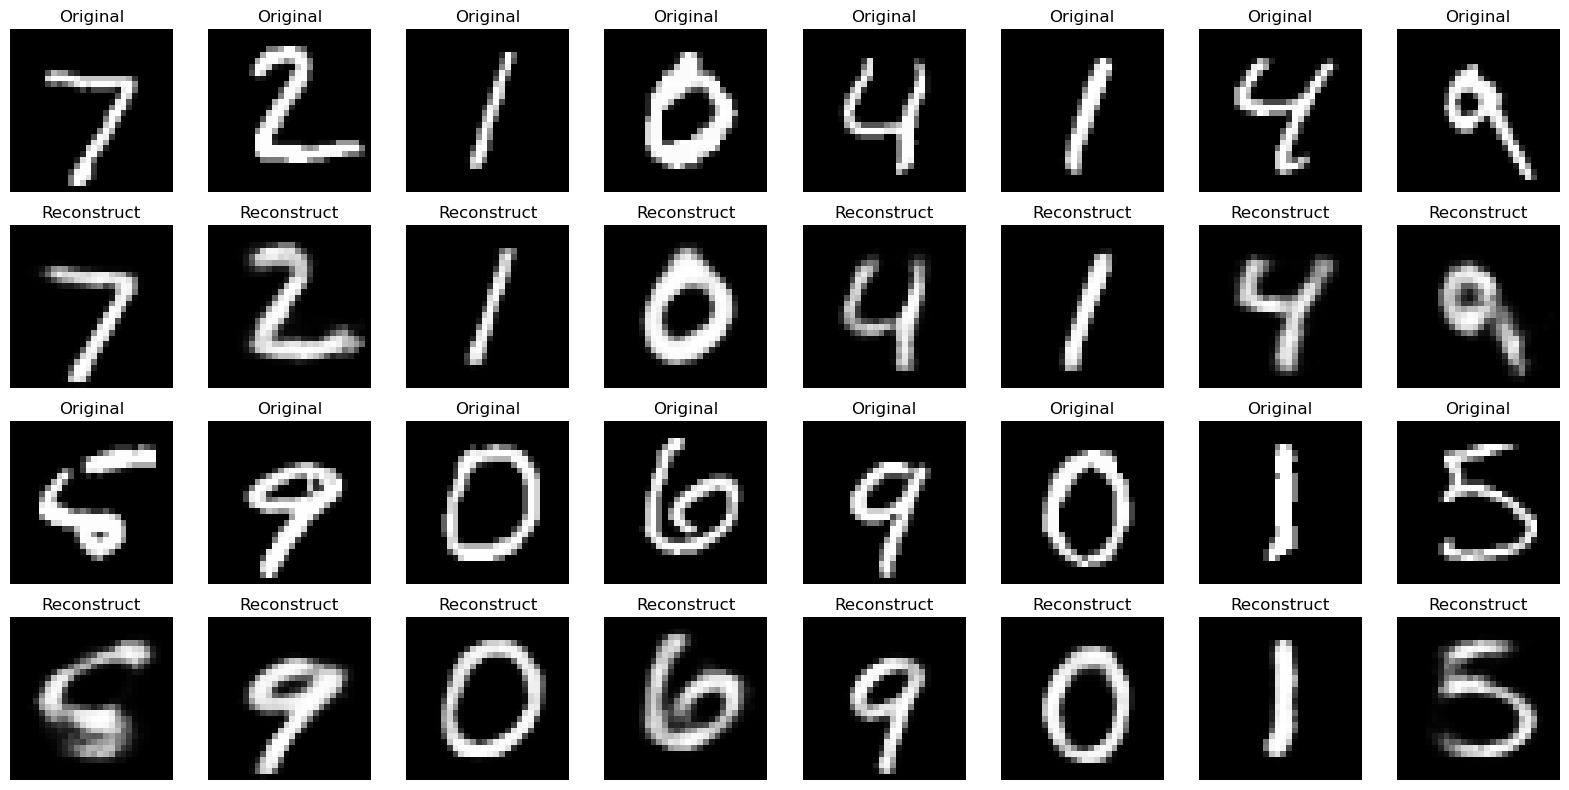

In [10]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

model.eval() 

with torch.no_grad(): 
	test_loss = 0
	for data, _ in test_loader: 
		#data=data.to(device) 
		data = data.view(data.size(0), -1) 
		recon_data = model(data) 
		test_loss += criterion(recon_data, data).item() 
	
	test_loss /= len(test_loader.dataset) 
	print('Test Loss: {:.6f}'.format(test_loss)) 
	
	# Plot some input images and their reconstructions 
	data, _ = next(iter(test_loader)) 
	#data=data.to(device) 
	data = data.view(data.size(0), -1) 
	recon_data = model(data) 
	
	fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16,8)) 
	for i in range(0,4,2): 
		for j in range(8): 
			k = k = j if i == 0 else 8+j 
			axes[i, j].imshow(data[k].cpu().view(28, 28), cmap='gray') 
			axes[i, j].set_title('Original') 
			axes[i, j].set_axis_off() 

			axes[i+1, j].imshow(recon_data[k].cpu().view(28, 28), cmap='gray') 
			axes[i+1, j].set_title('Reconstruct') 
			axes[i+1, j].set_axis_off() 

	fig.tight_layout() 
	plt.show()
